# Project 2 - Ames Housing Data and Kaggle Challenge
---
### Prompt:

We are tasked with creating a regression model based on the Ames Housing Dataset. This model will predict the price of a house at sale.

The Ames Housing Dataset is an exceptionally detailed and robust dataset with over 70 columns of different features relating to houses. As part of this project, we are:

- creating models over time, 
- using train-test splits, cross-validation, and data with unknown values for the target to simulate the modeling process

The Ames Housing Dataset used in this project can be found [here.](https://www.kaggle.com/c/dsi-us-5-project-2-regression-challenge/data)

## 1. Data Cleansing

First, load necessary modules

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet

from scipy import stats
from scipy.stats import norm

%matplotlib inline

Then, load your data and explore it

In [2]:
train = pd.read_csv('../data/train.csv', index_col='Id')

Let's look at how many rows and columns there are in the training set:

In [3]:
train.shape

(2051, 80)

Let's also look at the column names and remove any spaces:

In [4]:
train.columns = train.columns.str.replace(' ', '')

Let's explore how many null values there are in total:

In [5]:
train.isnull().sum().sum()

9822

... and how many null values there are in each column:

In [6]:
count = 0
for row, vals in train.isnull().sum().items():
    if vals > 0:
        print(row, vals)
        count += 1
print(count)

LotFrontage 330
Alley 1911
MasVnrType 22
MasVnrArea 22
BsmtQual 55
BsmtCond 55
BsmtExposure 58
BsmtFinType1 55
BsmtFinSF1 1
BsmtFinType2 56
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
FireplaceQu 1000
GarageType 113
GarageYrBlt 114
GarageFinish 114
GarageCars 1
GarageArea 1
GarageQual 114
GarageCond 114
PoolQC 2042
Fence 1651
MiscFeature 1986
26


There are 26 columns in the train set with null values. Let's explore each one, one at a time.

### LotFrontage

First, let's do Lot Frontage. We know there are 330 null values, so let's fill those null values in with the mean of the neighborhood's lot frontage.

In [7]:
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

Let's now take a look and see if ALL the null values have been filled in.

In [8]:
train[train['LotFrontage'].isnull()][['Neighborhood', 'LotFrontage']]

Neighborhood  LotFrontage
Id                            
2257      GrnHill          NaN
2789      Landmrk          NaN
2893      GrnHill          NaN

Wow! It looks like two of the neighborhoods didn't have any values to calculate the mean to fill in. Let's just fill these in with the mean of the whole dataset.

In [9]:
train['LotFrontage'] = train['LotFrontage'].fillna(value=train['LotFrontage'].mean())

Was it successful?

In [10]:
train[train['LotFrontage'].isnull()][['Neighborhood', 'LotFrontage']]

Empty DataFrame
Columns: [Neighborhood, LotFrontage]
Index: []

Yes! Let's see what values got filled in.

In [11]:
train.loc[[463, 1121, 1211]][['LotFrontage']]

/Users/namanbhandari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


LotFrontage
Id               
463          48.0
1121          NaN
1211          NaN

### Alley

Great, looks good. Now, let's do Alley. Let's just make the null values equal 'None'.

In [12]:
train.loc[train["Alley"].isnull(), 'Alley'] = 'None'

Spot-check...

In [13]:
train['Alley'].isnull().sum()

0

### MasVnrType

Great, looks good. Next, let's do Mas Vnr Type.

In [14]:
train['MasVnrType'].value_counts()

None       1218
BrkFace     630
Stone       168
BrkCmn       13
Name: MasVnrType, dtype: int64

There are many "None" values. Let's fill in the null values in this column with "None".

In [15]:
train.loc[train['MasVnrType'].isnull(), 'MasVnrType'] = 'None'

In [16]:
train['MasVnrType'].value_counts().sum()

2051

### MasVnrArea

Now let's do MasVnrArea. The null values are likely a result of there being no Masonry Veneer at all, but let's check this:

In [17]:
train[train['MasVnrArea'].isnull()][['MasVnrArea', 'MasVnrType']]

MasVnrArea MasVnrType
Id                         
2393         NaN       None
2383         NaN       None
539          NaN       None
518          NaN       None
2824         NaN       None
1800         NaN       None
1455         NaN       None
1120         NaN       None
1841         NaN       None
1840         NaN       None
2230         NaN       None
1123         NaN       None
1784         NaN       None
485          NaN       None
1752         NaN       None
1185         NaN       None
1128         NaN       None
1096         NaN       None
2261         NaN       None
2456         NaN       None
1728         NaN       None
56           NaN       None

Our assumption is correct, so let's fill MasVnrArea with zeros.

In [18]:
train['MasVnrArea'].fillna(0, inplace=True)

And check to make sure it worked:

In [19]:
train[train['MasVnrArea'].isnull()][['MasVnrArea', 'MasVnrType']].head()

Empty DataFrame
Columns: [MasVnrArea, MasVnrType]
Index: []

### BsmtQual / BsmtCond / BsmtExposure / BsmtFinType1 / BsmtFinType2

Next, let's do BsmtQual (height of basement) and BsmtCond (general condition of basement). Here, null values mean there is no basement, so let's replace null values with the string 'None'.

In [20]:
bsmt_cols=['BsmtQual',
             'BsmtCond',
             'BsmtExposure',
             'BsmtFinType1',
             'BsmtFinType2',]
train[bsmt_cols][train['BsmtQual'].isnull()==True].head()

BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2
Id                                                           
807       NaN      NaN          NaN          NaN          NaN
811       NaN      NaN          NaN          NaN          NaN
781       NaN      NaN          NaN          NaN          NaN
888       NaN      NaN          NaN          NaN          NaN
1554      NaN      NaN          NaN          NaN          NaN

In [21]:
for item in bsmt_cols:
    if train[item].dtype==np.object:
        train.loc[train[item].isnull(), item] = 'None'
    else:
        train.loc[train[item].isnull(), item] = 0

### FireplaceQu
Next, let's do FireplaceQu (Fireplace Quality). Here, null values mean there is no fireplace, so let's replace null values with the string 'None'.

In [22]:
train['FireplaceQu'].value_counts().sum()

1051

In [23]:
train.loc[train["FireplaceQu"].isnull(), 'FireplaceQu'] = 'None'

In [24]:
train['FireplaceQu'].value_counts().sum()

2051

### Garages
For the columns with missing data from Garage category, the equal number of missing values seems to indicate that the rows with null values are simply properties without garage. Let's take a look:

In [25]:
garage_cols=['GarageType',
             'GarageQual',
             'GarageCond',
             'GarageYrBlt',
             'GarageFinish',
             'GarageArea']
train[garage_cols][train['GarageType'].isnull()==True].head()

GarageType GarageQual GarageCond  GarageYrBlt GarageFinish  GarageArea
Id                                                                         
2243        NaN        NaN        NaN          NaN          NaN         0.0
330         NaN        NaN        NaN          NaN          NaN         0.0
2278        NaN        NaN        NaN          NaN          NaN         0.0
2235        NaN        NaN        NaN          NaN          NaN         0.0
2084        NaN        NaN        NaN          NaN          NaN         0.0

In [26]:
for item in garage_cols:
    if train[item].dtype==np.object:
        train.loc[train[item].isnull(), item] = 'None'
    else:
        train.loc[train[item].isnull(), item] = 0

### Fence / PoolQC / MiscFeature
Let's make all the null values equal to 'None' for these.

In [27]:
fence_pool_misc=['Fence',
             'PoolQC',
             'MiscFeature']
train[fence_pool_misc][train['Fence'].isnull()==True].head()

Fence PoolQC MiscFeature
Id                          
109   NaN    NaN         NaN
544   NaN    NaN         NaN
153   NaN    NaN         NaN
318   NaN    NaN         NaN
255   NaN    NaN         NaN

In [28]:
for item in fence_pool_misc:
    if train[item].dtype==np.object:
        train.loc[train[item].isnull(), item] = 'None'
    else:
        train.loc[train[item].isnull(), item] = 0

### Remaining Features
Let's take a look at the remaining features all together:

In [29]:
count = 0
remaining = []
for row, vals in train.isnull().sum().items():
    if vals > 0:
        count += 1
        remaining.append(row)
display(remaining)
print(count)

['BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageCars']

7


Let's quickly view the rows that have missing items for these features:

In [30]:
train[train.isnull().any(axis=1)][remaining]

BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  \
Id                                                                   
1498         0.0         0.0        0.0          0.0           NaN   
1342         NaN         NaN        NaN          NaN           NaN   
2237       548.0         0.0      311.0        859.0           0.0   

      BsmtHalfBath  GarageCars  
Id                              
1498           NaN         2.0  
1342           NaN         1.0  
2237           0.0         NaN

It seems reasonable to replace all of these values with zeros. Let's run our for loop again and then re-view the dataframe:

In [31]:
for item in remaining:
    if train[item].dtype==np.object:
        train.loc[train[item].isnull(), item] = 'None'
    else:
        train.loc[train[item].isnull(), item] = 0

In [32]:
train[train.isnull().any(axis=1)][remaining]

Empty DataFrame
Columns: [BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath, GarageCars]
Index: []

Great, they've all been replaced with zeros successfully. Any remaining null values in our training data?

In [33]:
count = 0
for row, vals in train.isnull().sum().items():
    if vals > 0:
        print(row, vals)
        count += 1
print(count)

0


Woo-hoo! Nice clean dataset with no null values. 

### Outliers

Now let's explore a scatterplot to see if any outliers exist.

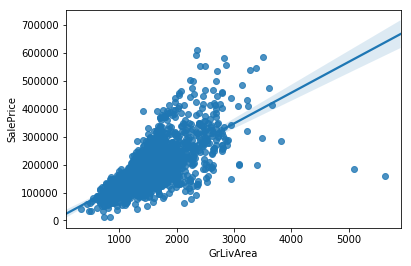

In [34]:
sns.regplot(x="GrLivArea", y="SalePrice", data=train)

Looks like there are two outliers at GrLivArea > 5000, so let's drop these.

In [35]:
train = train[(train['GrLivArea'] < 5000)]
train.shape

(2049, 80)

Let's also see if there are any homes below 20,000.

In [36]:
train[(train['SalePrice'] < 20000)][['SalePrice', 'GrLivArea']]

SalePrice  GrLivArea
Id                        
1554      13100        733
182       12789        832

Let's drop these two homes. They are priced too low. We should have 2047 rows remaining afterwards.

In [37]:
train = train[(train['SalePrice'] > 20000)]
train.shape

(2047, 80)

### Un-needed Columns

Let's also drop unneeded columns such as PID:

In [38]:
train = train.drop(labels=['PID'], axis = 1)

### Unwanted zero values (that may skew the data)

Let's also make sure that there are no zeros in any of the year-related columns:

/Users/namanbhandari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/namanbhandari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/namanbhandari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/namanbhandari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


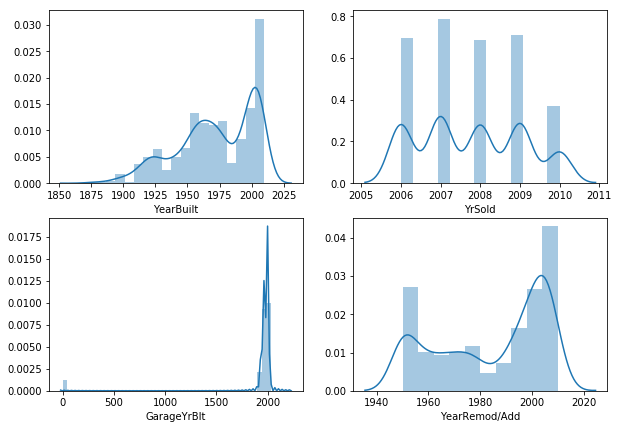

In [39]:
fig, ax = plt.subplots(2,2, figsize = (10,7))
sns.distplot(train['YearBuilt'], ax=ax[0,0])
sns.distplot(train['YrSold'], ax=ax[0,1])
sns.distplot(train['GarageYrBlt'], ax=ax[1,0])
sns.distplot(train['YearRemod/Add'], ax=ax[1,1])

Looks like GarageYrBlt has a few zero values! Do any these homes actually have garages?

In [40]:
train[(train['GarageYrBlt'] == 0) & 
      (train['GarageType'] != 'None')][['GarageType', 'GarageYrBlt', 'YearBuilt']]

GarageType  GarageYrBlt  YearBuilt
Id                                     
2237     Detchd          0.0       1923

One does, so we will make its GarageYrBlt equal to its YearBuilt

In [41]:
train['GarageYrBlt'].loc[2237] = train['YearBuilt'].loc[2237]

/Users/namanbhandari/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [42]:
train.loc[2237][['GarageType', 'YearBuilt', 'GarageYrBlt']]

GarageType     Detchd
YearBuilt        1923
GarageYrBlt      1923
Name: 2237, dtype: object

From the chart, it also looks like there is a GarageYrBlt in the future, let's check it:

In [43]:
train[(train['GarageYrBlt'] > 2010) & 
      (train['GarageType'] != 'None')][['GarageType', 'GarageYrBlt']]

GarageType  GarageYrBlt
Id                          
2261     Attchd       2207.0

What year was this home built?

In [44]:
train['YearBuilt'].loc[2261]

2006

Let's set the GarageYrBlt for that home to 2006 then.

In [45]:
train['GarageYrBlt'].loc[2261] = train['YearBuilt'].loc[2261]

/Users/namanbhandari/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [46]:
train.loc[2261][['GarageType', 'YearBuilt', 'GarageYrBlt']]

GarageType     Attchd
YearBuilt        2006
GarageYrBlt      2006
Name: 2261, dtype: object

For the rest, let's change the values to the mean of the data so the zeros dont skew everything. First let's get the mean of all the non-zero data:

In [47]:
garage_year_built_mean = train[(train['GarageYrBlt'] != 0)][['GarageYrBlt']].mean().round(0)

In [48]:
garage_year_built_mean = float(garage_year_built_mean)

Spot-check: We can see that the overall mean including the zeros is 1869 (obviously wrong, and not what we want):

In [49]:
train['GarageYrBlt'].mean()

1869.361504640938

So now, let's replace all ZERO values with the mean of the non-zero data:

In [50]:
train.loc[train['GarageYrBlt'] == 0, 'GarageYrBlt'] = garage_year_built_mean

The mean Garage Year Built is now more reasonable:

In [51]:
train['GarageYrBlt'].mean()

1978.6077186126038

## 2. Feature Engineering

Let's see if we can spot any trends in the data to determine whether we can turn those trends into new features in our data. Based on our previously-plotted year data, we saw a couple of modes in the distribution of the data. It might be a good idea to turn these modes into clusters.

### Year Built Feature

/Users/namanbhandari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


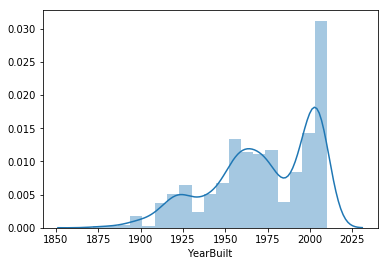

In [52]:
sns.distplot(train['YearBuilt'])

We can see three general "groupings" in Year Built -- one from 1870 to 1940, one from 1940 to 1980, and one from 1980 to 2010. Let's create three groups based on this and create a new column in our data that represents each wave.

In [53]:
def wave(value):
    if ((value > 1870) & (value <= 1940)):
        return 'Wave1'
    elif ((value > 1940) & (value <= 1980)):
        return 'Wave2'
    elif ((value > 1980) & (value <= 2010)):
        return 'Wave3'
    return ''

train['BuildWave'] = train['YearBuilt'].apply(wave)

In [54]:
train['BuildWave'].head()

Id
109    Wave2
544    Wave3
153    Wave2
318    Wave3
255    Wave1
Name: BuildWave, dtype: object

### Remodeled Feature

Let's add a column for whether or not a house has been remodeled, which could affect the price:

In [55]:
train.loc[train['YearRemod/Add'] != train['YearBuilt'], 'Remodeled'] = 'Remodeled'

In [56]:
train.loc[train['YearRemod/Add'] == train['YearBuilt'], 'Remodeled'] = 'Not_Remodeled'

In [57]:
train['Remodeled'].head(10)

Id
109         Remodeled
544         Remodeled
153         Remodeled
318         Remodeled
255         Remodeled
138         Remodeled
2827        Remodeled
145     Not_Remodeled
1942    Not_Remodeled
1956    Not_Remodeled
Name: Remodeled, dtype: object

### MSSubClass into a Categorical Feature

Let's also MSSubClass (which would be interpreted as numbers) into a categorical feature, so we can turn it into dummy variables later.

In [58]:
train['MSSubClass'] = train['MSSubClass'].astype(str)
train['YrSold'] = train['YrSold'].astype(str)

### 2nd Floor Feature

Let's add a feature that tells us whether or not a second floor exists. Then, we can drop the 1st floor and 2nd floor sq. ft. features because they are redundant given the existence of the Gr Liv Area feature.

In [59]:
train.loc[train['2ndFlrSF'] > 0, '2ndFloor'] = 'Yes'

In [60]:
train.loc[train['2ndFlrSF'] == 0, '2ndFloor'] = 'No'

In [61]:
train.drop(['1stFlrSF', '2ndFlrSF', 'LowQualFinSF'], axis=1, inplace=True)

### Basement Feature

Let's add a feature that tells us whether or not a basement exists. Then, we can drop the sq. ft. features related to basement because they are redundant given the existence of the Total Bsmt SF feature.

In [62]:
train.loc[train['TotalBsmtSF'] > 0, 'Basement'] = 'Yes'

In [63]:
train.loc[train['TotalBsmtSF'] == 0, 'Basement'] = 'No'

In [64]:
train.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], axis=1, inplace=True)

### Drop YearBuilt

Let's drop the YearBuilt feature as we created a Wave column instead.

In [65]:
train.drop(['YearBuilt'], axis=1, inplace=True)

### Other Correlations

Let's take a look and see if any of the many Garage features are correlated.

In [66]:
feat_list = train[[
 'GarageArea',
 'GarageCars']]

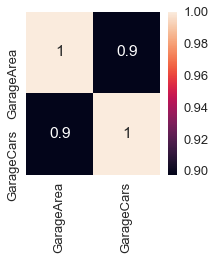

In [67]:
plt.figure(figsize=(3, 3))
sns.set(font_scale=1.3)
sns.heatmap(feat_list.corr(), annot=True)

It seems that GarageArea and GarageCars are highly correlated. Let's drop GarageArea since most home-buyers would likely pay more attention to the number of cars that fit than the area of the garage.

In [68]:
train.drop(['GarageArea'], axis=1, inplace=True)

## 4. Cleaning Kaggle Test Data

Let's clean our kaggle test data in the same method as training data so we can compare the two and also create dummy variables:

In [69]:
kaggle = pd.read_csv('../data/test.csv', index_col='Id')
kaggle.columns = kaggle.columns.str.replace(' ', '')

In [70]:
count = 0
for row, vals in kaggle.isnull().sum().items():
    if vals > 0:
        print(row, vals)
        count += 1

LotFrontage 160
Alley 821
MasVnrType 1
MasVnrArea 1
BsmtQual 25
BsmtCond 25
BsmtExposure 25
BsmtFinType1 25
BsmtFinType2 25
Electrical 1
FireplaceQu 422
GarageType 44
GarageYrBlt 45
GarageFinish 45
GarageQual 45
GarageCond 45
PoolQC 875
Fence 707
MiscFeature 838


### Basic Cleaning

In [71]:
kaggle['LotFrontage'] = kaggle.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

In [72]:
kaggle.loc[kaggle["Alley"].isnull(), 'Alley'] = 'None'

In [73]:
kaggle.loc[kaggle['MasVnrType'].isnull(), 'MasVnrType'] = 'None'

In [74]:
kaggle['MasVnrArea'].fillna(0, inplace=True)

In [75]:
for item in bsmt_cols:
    if kaggle[item].dtype==np.object:
        kaggle.loc[kaggle[item].isnull(), item] = 'None'
    else:
        kaggle.loc[kaggle[item].isnull(), item] = 0

In [76]:
for item in garage_cols:
    if kaggle[item].dtype==np.object:
        kaggle.loc[kaggle[item].isnull(), item] = 'None'
    else:
        kaggle.loc[kaggle[item].isnull(), item] = 0

In [77]:
kaggle.loc[kaggle["Electrical"].isnull(), 'Electrical'] = 'None'

In [78]:
kaggle.loc[kaggle["FireplaceQu"].isnull(), 'FireplaceQu'] = 'None'

In [79]:
for item in fence_pool_misc:
    if kaggle[item].dtype==np.object:
        kaggle.loc[kaggle[item].isnull(), item] = 'None'
    else:
        kaggle.loc[kaggle[item].isnull(), item] = 0

In [80]:
kaggle = kaggle.drop(labels=['PID'], axis = 1)

In [81]:
kaggle_garage_year_built_mean = kaggle[(kaggle['GarageYrBlt'] != 0)][['GarageYrBlt']].mean().round(0)
kaggle_garage_year_built_mean = float(kaggle_garage_year_built_mean)
kaggle.loc[kaggle['GarageYrBlt'] == 0, 'GarageYrBlt'] = kaggle_garage_year_built_mean

### Recreate Feature Engineering

Now let's add a Wave Built column as before:

In [82]:
kaggle['BuildWave'] = kaggle['YearBuilt'].apply(wave)

Now let's add a Remodeled column as before:

In [83]:
kaggle.loc[kaggle['YearRemod/Add'] != kaggle['YearBuilt'], 'Remodeled'] = 'Remodeled'

In [84]:
kaggle.loc[kaggle['YearRemod/Add'] == kaggle['YearBuilt'], 'Remodeled'] = 'Not_Remodeled'

Let's also MSSubClass (which would be interpreted as numbers) into a categorical feature, so we can turn it into dummy variables later.

In [85]:
kaggle['MSSubClass'] = kaggle['MSSubClass'].astype(str)
kaggle['YrSold'] = kaggle['YrSold'].astype(str)

Let's add a feature that tells us whether or not a second floor exists. Then, we can drop the 1st floor and 2nd floor sq. ft. features because they are redundant given the existence of the Gr Liv Area feature.

In [86]:
kaggle.loc[kaggle['2ndFlrSF'] > 0, '2ndFloor'] = 'Yes'

In [87]:
kaggle.loc[kaggle['2ndFlrSF'] == 0, '2ndFloor'] = 'No'

In [88]:
kaggle.drop(['1stFlrSF', '2ndFlrSF', 'LowQualFinSF'], axis=1, inplace=True)

Let's add a feature that tells us whether or not a basement exists. Then, we can drop the sq. ft. features related to basement because they are redundant given the existence of the Total Bsmt SF feature.

In [89]:
kaggle.loc[kaggle['TotalBsmtSF'] > 0, 'Basement'] = 'Yes'

In [90]:
kaggle.loc[kaggle['TotalBsmtSF'] == 0, 'Basement'] = 'No'

In [91]:
kaggle.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], axis=1, inplace=True)

### Drop YearBuilt

Let's drop the YearBuilt feature as we created a Wave column instead.

In [92]:
kaggle.drop(['YearBuilt'], axis=1, inplace=True)

In [93]:
kaggle.drop(['GarageArea'], axis=1, inplace=True)

## 5. Basic Visualization

In [94]:
neighborhoods_sorted = train.groupby('Neighborhood')[['SalePrice', 'Neighborhood']].median().sort_values('SalePrice')

In [95]:
neighborhoods_sorted.index

Index(['MeadowV', 'IDOTRR', 'BrDale', 'OldTown', 'Edwards', 'BrkSide',
       'Sawyer', 'SWISU', 'Landmrk', 'Blueste', 'NAmes', 'NPkVill', 'Mitchel',
       'Gilbert', 'SawyerW', 'NWAmes', 'Greens', 'Blmngtn', 'Crawfor',
       'CollgCr', 'Timber', 'Somerst', 'ClearCr', 'Veenker', 'GrnHill',
       'NoRidge', 'NridgHt', 'StoneBr'],
      dtype='object', name='Neighborhood')

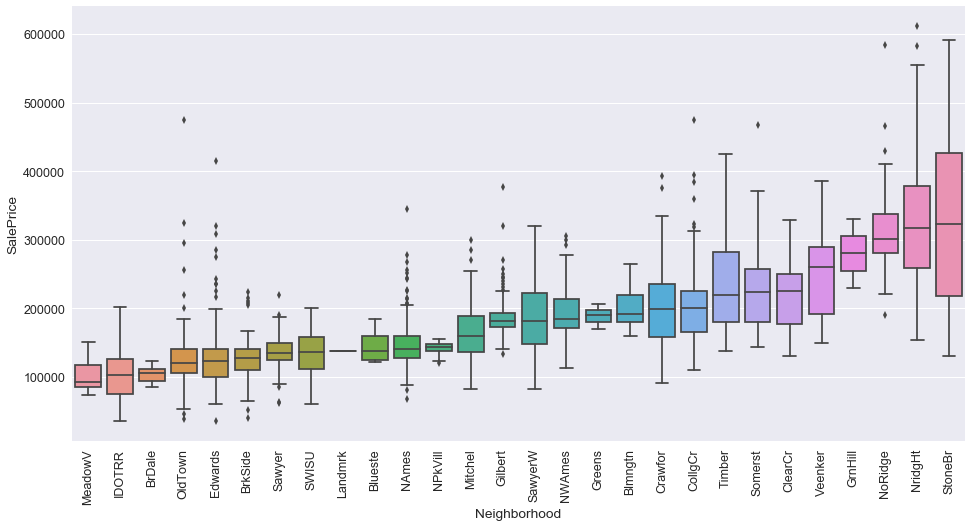

In [96]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.25)
plt.xticks(rotation=90)
sns.boxplot(data=train, x=train['Neighborhood'], y='SalePrice', order = neighborhoods_sorted.index)

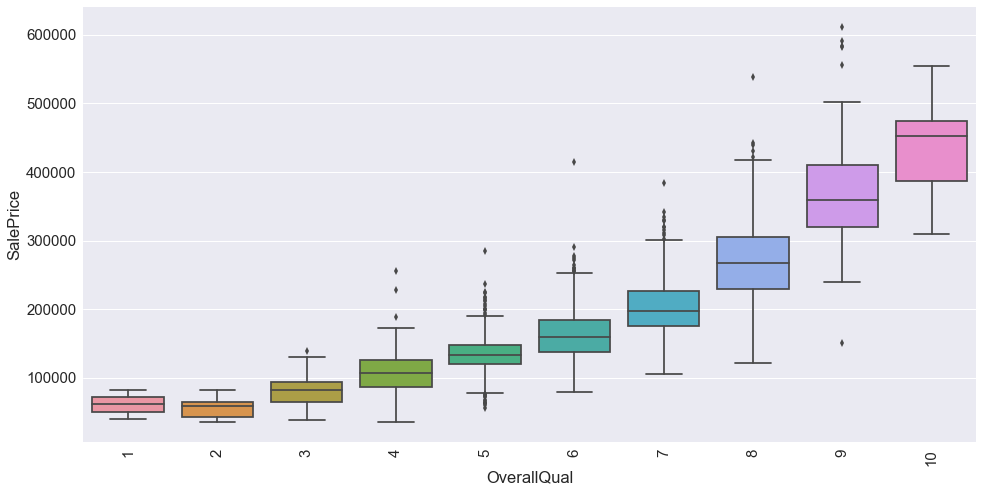

In [97]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.5)
plt.xticks(rotation=90)
sns.boxplot(data=train, x=train['OverallQual'], y='SalePrice')

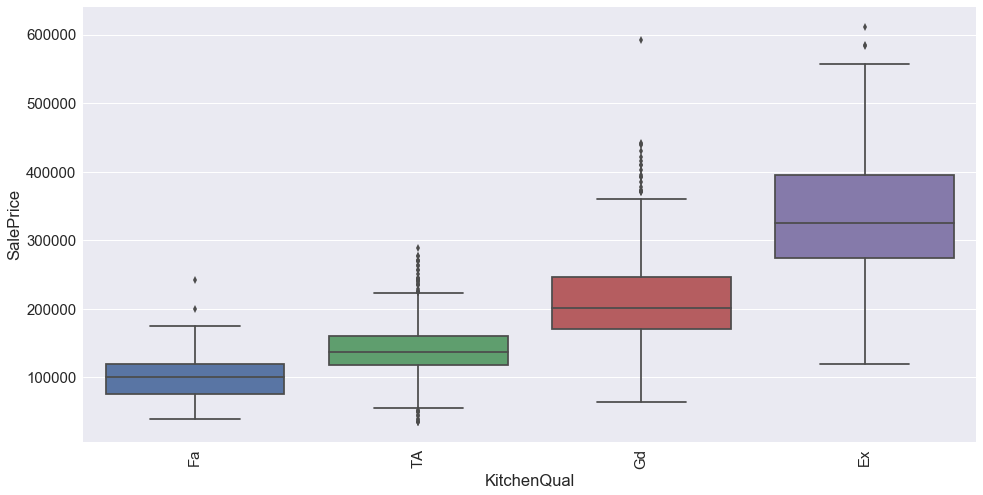

In [98]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.5)
plt.xticks(rotation=90)
sns.boxplot(data=train, x=train['KitchenQual'], y='SalePrice', order = ['Fa', 'TA', 'Gd', 'Ex'])

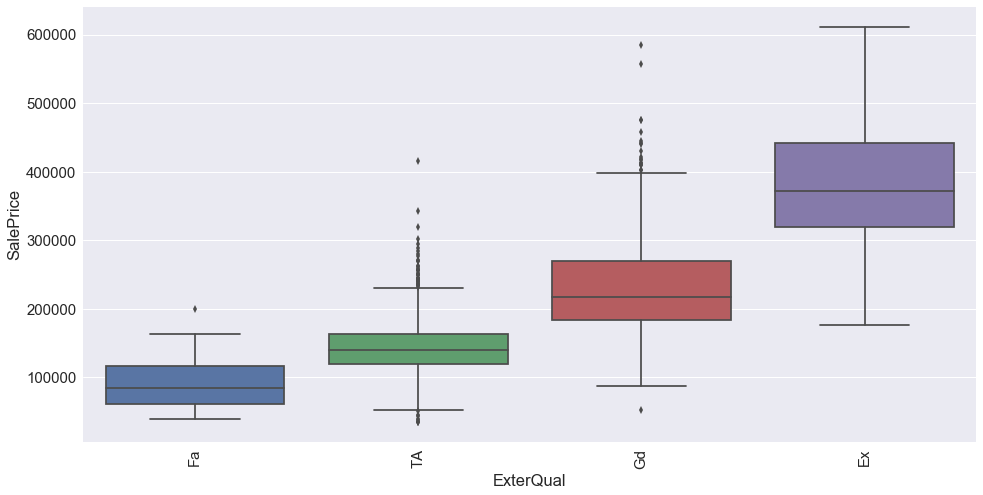

In [99]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.5)
plt.xticks(rotation=90)
sns.boxplot(data=train, x=train['ExterQual'], y='SalePrice', order = ['Fa', 'TA', 'Gd', 'Ex'])

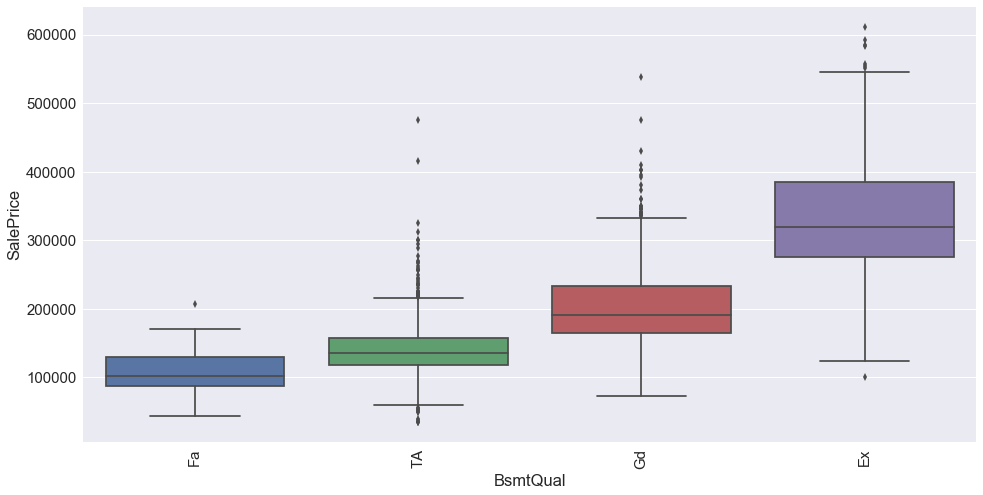

In [100]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.5)
plt.xticks(rotation=90)
sns.boxplot(data=train, x=train['BsmtQual'], y='SalePrice', order = ['Fa', 'TA', 'Gd', 'Ex'])

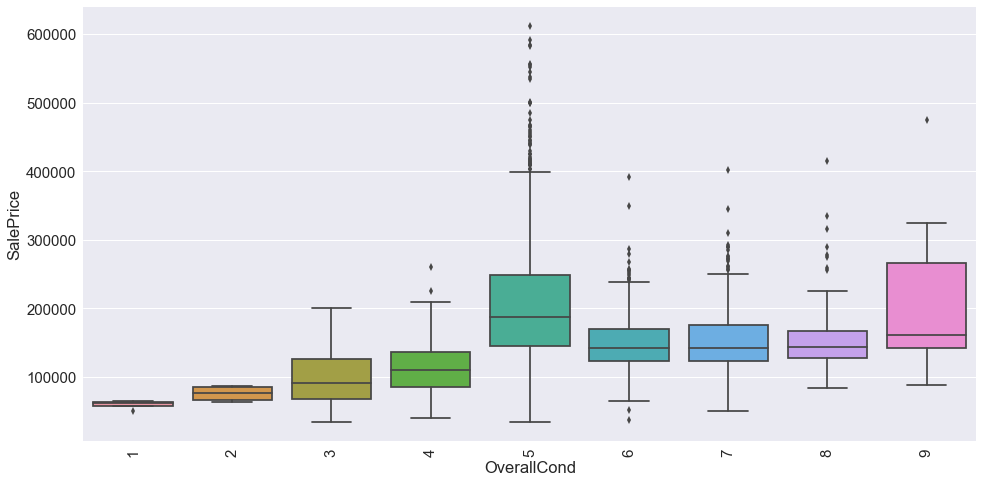

In [101]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.5)
plt.xticks(rotation=90)
sns.boxplot(data=train, x=train['OverallCond'], y='SalePrice')

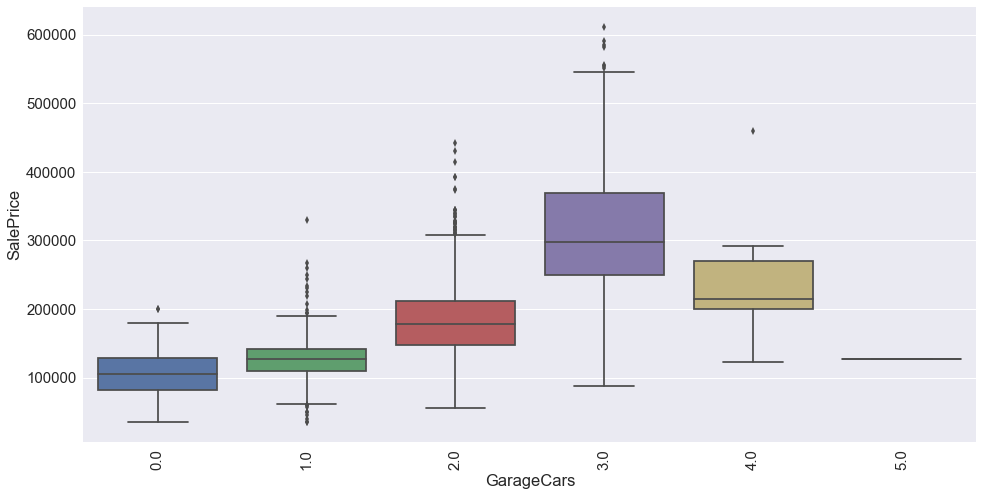

In [102]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.5)
plt.xticks(rotation=90)
sns.boxplot(data=train, x=train['GarageCars'], y='SalePrice')

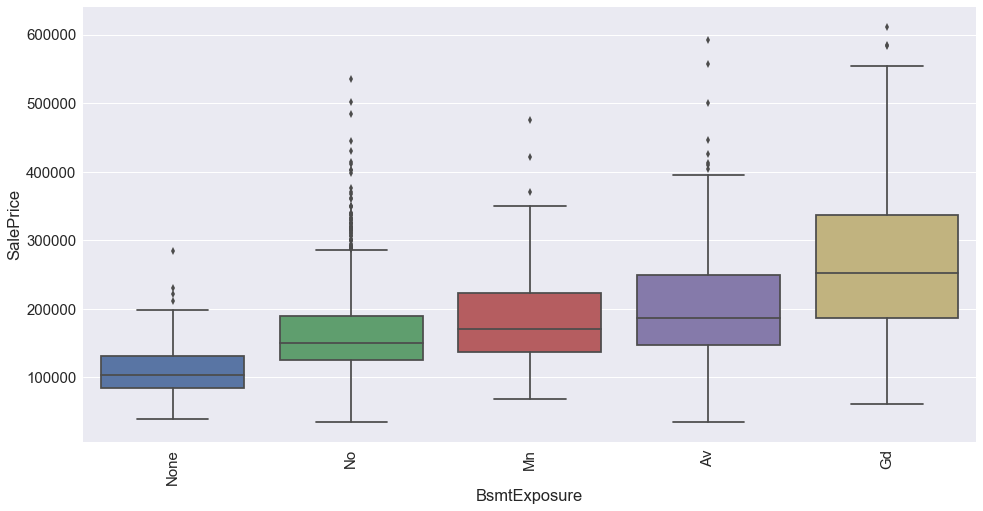

In [103]:
plt.figure(figsize=(16,8))
sns.set(font_scale=1.5)
plt.xticks(rotation=90)
sns.boxplot(data=train, x=train['BsmtExposure'], y='SalePrice', order = ['None', 'No', 'Mn', 'Av', 'Gd'])

/Users/namanbhandari/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


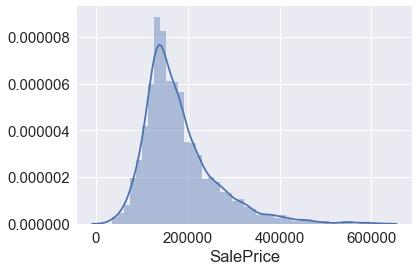

In [104]:
sns.distplot(train['SalePrice'])

In [105]:
train['SalePrice'].mean(), train['SalePrice'].median()

(181643.6829506595, 162500.0)

## 6. Getting Dummies

Let's create dummy variables for both our train and kaggle datasets.

In [106]:
train = pd.get_dummies(train)
kaggle = pd.get_dummies(kaggle)

Let's compare the shape of each dataframe to see how many features there are.

In [107]:
train.shape, kaggle.shape

((2047, 322), (879, 305))

There are differences in the number of features, so let's create a set of columns that are in the train dataset that are not in the kaggle dataset, and add those columns to the kaggle dataset and set them equal to 0.

In [108]:
set1 = set(train.columns).difference(kaggle.columns)

In [109]:
for item in set1:
    kaggle[item] = 0

Let's now retrieve only the columns that are in the train dataset...

In [110]:
kaggle[train.columns].head()

LotFrontage  LotArea  OverallQual  OverallCond  YearRemod/Add  \
Id                                                                    
2658    69.000000     9142            6            8           1950   
2718    79.222222     9662            5            4           1977   
2414    58.000000    17104            7            5           2006   
1989    60.000000     8520            5            6           2006   
625     75.254545     9500            6            5           1963   

      MasVnrArea  TotalBsmtSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
Id                                                                     
2658         0.0       1020.0       1928           0.0           0.0   
2718         0.0       1967.0       1967           0.0           0.0   
2414         0.0        654.0       1496           1.0           0.0   
1989         0.0        968.0        968           0.0           0.0   
625        247.0       1394.0       1394           1.0           0.0   

          ...       SaleType_WD   BuildWave_Wave1  BuildWave_Wave2  \
Id        ...                                                        
2658      ...                  1                1                0   
2718      ...                  1                0                1   
2414      ...                  0                0                0   
1989      ...                  1                1                0   
625       ...                  1                0                1   

      BuildWave_Wave3  Remodeled_Not_Remodeled  Remodeled_Remodeled  \
Id                                                                    
2658                0                        0                    1   
2718                0                        1                    0   
2414                1                        1                    0   
1989                0                        0                    1   
625                 0                        1                    0   

      2ndFloor_No  2ndFloor_Yes  Basement_No  Basement_Yes  
Id                                                          
2658            0             1            0             1  
2718            1             0            0             1  
2414            0             1            0             1  
1989            1             0            0             1  
625             1             0            0             1  

[5 rows x 322 columns]

And shrink the kaggle dataset to contain only the columns that are also present in the train dataset. This way the number of features in both datasets will match.

In [111]:
kaggle = kaggle[train.columns]

## 7. Modeling

### Create X and y to model against

Let's create a target $y$ to model against, in our case `Sale Price`. Let's also drop Sale Price from our train data set (we'll call this $X$) and our kaggle dataset (which is our test dataset, which we'll keep calling kaggle).

In [112]:
X = train.drop('SalePrice', 1)
kaggle_y = kaggle['SalePrice']
kaggle = kaggle.drop('SalePrice', 1)
y = train['SalePrice']

In [113]:
X.shape

(2047, 321)

In [114]:
kaggle.shape

(879, 321)

### Train / Test Split

Let's now split our data into test and train data so we can score our training data against test data to check the model's predictive power.

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [116]:
kf = KFold(n_splits=10, shuffle=True, random_state = 42)

### Baseline Linear Regression Using All Features

Linear regression creates a model in the form $y = m_1x_1 + m_2x_2 + ... + m_px_p + B$ that helps us predict a desired output given certain inputs.

In [117]:
lr = LinearRegression()

In [118]:
scores = cross_val_score(lr, X_train, y_train, cv=kf)
print("All KFold scores:",scores.round(3))
print("Average of KFold scores:",scores.mean().round(3))

All KFold scores: [0.886 0.897 0.908 0.929 0.906 0.909 0.912 0.879 0.913 0.906]
Average of KFold scores: 0.904


In [119]:
scores = cross_val_score(lr, X_test, y_test, cv=kf)
print("All KFold scores:",scores.round(3))
print("Average of KFold scores:",scores.mean().round(3))

All KFold scores: [0.885 0.87  0.877 0.712 0.896 0.822 0.881 0.907 0.823 0.754]
Average of KFold scores: 0.843


In [120]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9432432556400012, 0.9093647125488004)

In [121]:
mean_squared_error(y_train, lr.predict(X_train)) ** 0.5, mean_squared_error(y_test,lr.predict(X_test)) ** 0.5

(18806.657244262675, 24001.00363142321)

So now we have a baseline $R^2$ score and RMSE for our data. But what happens if we run a regression using just GrLivArea as our sole feature in our model?

Let's also look at how GrLivArea alone predicts SalePrice (GrLivArea, aka Total Square Feet, is the most common, best-understood factor in analyzing home prices... heuristically speaking):

### Baseline Linear Regression Using GrLivArea Only

In [122]:
lrgla = LinearRegression()

In [123]:
X_train_gla = pd.DataFrame(X_train['GrLivArea'])
X_test_gla = pd.DataFrame(X_test['GrLivArea'])

In [124]:
lrgla.fit(X_train_gla, y_train)
lrgla.score(X_train_gla, y_train), lrgla.score(X_test_gla, y_test)

(0.5337023915588737, 0.4633653057443616)

In [125]:
mean_squared_error(y_train, lrgla.predict(X_train_gla)) ** 0.5, mean_squared_error(y_test,lrgla.predict(X_test_gla)) ** 0.5

(53905.67214981683, 58400.97772375875)

This results in a mediocre R2 score and mediocre RMSE. This is our true baseline. Our model should beat this.

In [126]:
lrgla.coef_, lrgla.intercept_

(array([120.80642742]), 2124.7449122137914)

These are the inputs to our simple linear regression equation in the form of $y = mx + B$.

Let's also plot the above equation, below.

In [127]:
m = float(lrgla.coef_)
B = float(lrgla.intercept_)

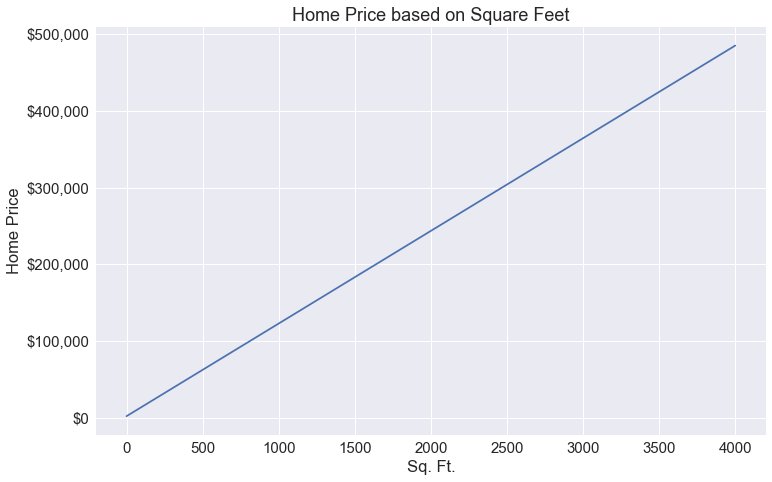

In [128]:
import matplotlib.ticker as mtick

fig, ax = plt.subplots(1, 1, figsize=(12, 7.5))

plt.xlabel('Sq. Ft.')
plt.ylabel('Home Price')
plt.title('Home Price based on Square Feet')

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

plt.plot([0, 4000], [m * 0 + B, m * 4000 + B]);

If we use just GrLivArea as the sole feature in our model (as most common home-buyers may), we get a mediocre $R^2$ and RMSE that may dramatically overprice (or underprice) the home in question.

### Scaling

Let's scale the data, re-run lr, and see what happens.

In [129]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [130]:
lr2 = LinearRegression()

In [131]:
lr2.fit(X_train_sc, y_train)
lr2.score(X_train_sc, y_train), lr2.score(X_test_sc, y_test)

(0.9431241503660162, -7.308033565710857e+23)

In [132]:
mean_squared_error(y_train, lr2.predict(X_train_sc)) ** 0.5, mean_squared_error(y_test,lr2.predict(X_test_sc)) ** 0.5

(18826.37999406858, 6.815237754558702e+16)

Terrible scores. This won't work. Let's try regularization methods like Lasso, which is a regression analysis method that performs both variable selection and regularization to minimize and/or zero-out beta coefficients for multiple features to enhance the prediction accuracy and interpretability of the statistical model it produces.

### Lasso CV

Instantiate the LassoCV model.

In [133]:
lcv = LassoCV()

Fit the model.

In [134]:
model_lcv = lcv.fit(X_train_sc, y_train)

Score the model.

In [135]:
lcv.score(X_train_sc, y_train), lcv.score(X_test_sc, y_test)

(0.9349634734131966, 0.9187587162335733)

View our mean squared errors.

In [136]:
mean_squared_error(y_train, lcv.predict(X_train_sc)) ** 0.5, mean_squared_error(y_test,lcv.predict(X_test_sc)) ** 0.5

(20131.750574704663, 22723.181278216016)

### Visualization of Lasso CV Coefficients

I now want to see which features are most important in my model and what its coefficients are. First, let's get the all the beta coefficients of our model, and also get all the names of out features into a DataFrame:

In [137]:
lcv_betas_df = pd.DataFrame(lcv.coef_, columns = ['betas'])
X_train_columns_df = pd.DataFrame(X_train.columns, columns = ['features'])

Now, let's combine the betas and feature names into one dataframe and set the index to the feature names column:

In [138]:
df = X_train_columns_df.join(lcv_betas_df)

In [139]:
df = df.set_index('features')

Let's find the absolute values of our betas, put them into our dataframe, and sort by the betas with the LARGEST overall magnitude. Those will be the most important to our model:

In [140]:
df['abs_betas'] = df['betas'].abs()

Let's get our top 10 betas that contribute positively to price, and bottom 10 betas that contribute negatively to price.

In [141]:
top_ten_betas = df.sort_values('abs_betas', ascending=False)['betas'].head(10)

In [142]:
bottom_ten_betas = df.sort_values('betas', ascending=False)['betas'].tail(10)

Assign feature names to top and bottom 10 betas.

In [143]:
top_ten_labels = top_ten_betas.index

In [144]:
bottom_ten_labels = bottom_ten_betas.index

Let's also get our intercept:

In [145]:
beta_0 = lcv.intercept_

Now let's plot our top 10 and bottom 10 betas and their feature names (labels) in a barplot!

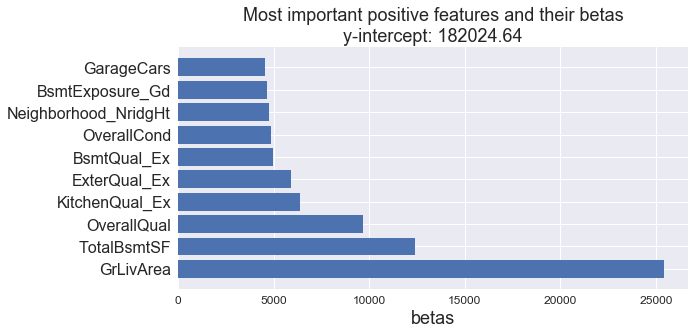

In [146]:
plt.figure(figsize=(10,5))
plt.barh(top_ten_labels, top_ten_betas)
plt.yticks(fontsize=16)
plt.xticks(fontsize=12)
plt.xlabel('betas', fontsize=18)
plt.title(f'Most important positive features and their betas\ny-intercept: {beta_0:0.02f}', fontsize=18)
plt.tight_layout()

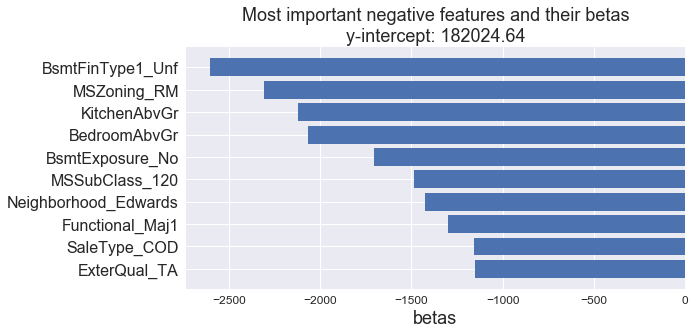

In [147]:
plt.figure(figsize=(10,5))
plt.barh(bottom_ten_labels, bottom_ten_betas)
plt.yticks(fontsize=16)
plt.xticks(fontsize=12)
plt.xlabel('betas', fontsize=18)
plt.title(f'Most important negative features and their betas\ny-intercept: {beta_0:0.02f}', fontsize=18)
plt.tight_layout()

In [148]:
top_std_list = []
for item in top_ten_labels:
    top_std_list.append(train[item].std())
    
top_std_df = pd.DataFrame(top_std_list)
top_std_df.columns = ['St. Devs.']
top_ten_labels_df = pd.DataFrame(top_ten_labels)
top_ten_stds = top_ten_labels_df.join(top_std_df)
top_ten_stds

features   St. Devs.
0             GrLivArea  485.506405
1           TotalBsmtSF  426.306715
2           OverallQual    1.415066
3        KitchenQual_Ex    0.259854
4          ExterQual_Ex    0.192670
5           BsmtQual_Ex    0.284684
6           OverallCond    1.102555
7  Neighborhood_NridgHt    0.236801
8       BsmtExposure_Gd    0.297647
9            GarageCars    0.765578

In [149]:
bottom_std_list = []
for item in bottom_ten_labels:
    bottom_std_list.append(train[item].std())
    
bottom_std_df = pd.DataFrame(bottom_std_list)
bottom_std_df.columns = ['St. Devs.']
bottom_ten_labels_df = pd.DataFrame(bottom_ten_labels)
bottom_ten_stds = bottom_ten_labels_df.join(bottom_std_df)
bottom_ten_stds

features  St. Devs.
0          ExterQual_TA   0.488162
1          SaleType_COD   0.172755
2       Functional_Maj1   0.076359
3  Neighborhood_Edwards   0.253314
4        MSSubClass_120   0.245674
5       BsmtExposure_No   0.475926
6          BedroomAbvGr   0.826787
7          KitchenAbvGr   0.209986
8           MSZoning_RM   0.360925
9      BsmtFinType1_Unf   0.455743

## 8. Model and Submit to Kaggle

In [150]:
kaggle_sc = ss.transform(kaggle)

In [151]:
preds = lcv.predict(kaggle_sc)

In [152]:
submission = pd.DataFrame(preds, index=kaggle.index, columns=['SalePrice'])

In [153]:
submission.sort_index(inplace=True)

In [154]:
submission.to_csv('../data/numeric_only_lcv8.csv')

In [155]:
!head ../data/numeric_only_lcv8.csv

Id,SalePrice
2,114076.60074794915
4,288984.5449104535
6,191724.86147096014
7,214851.95933203294
17,195622.1828725901
18,368083.0183566256
22,183840.13798679312
27,108944.09514034558
31,98097.0305549714
